<a href="https://colab.research.google.com/github/mursune/TFM_malaria/blob/main/TFM_code_AnnaMur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TFM - Anna Mur Suñé**

# Libraries and Mount Google Drive

In [ ]:
# Import the necessary libraries

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.patches as patches
import cv2
import torch
import shutil
import pandas as pd
!pip install supervision
import supervision as sv

import skimage
from skimage import io, feature, measure, exposure, color, morphology
from skimage.measure import regionprops, label, shannon_entropy
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import kurtosis, skew, entropy

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_predict

!pip install shap
import shap


!pip install torch
!pip intall torchvision
!pip install transformers
!pip install pycocotools
!pip install pillow
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from transformers import DetrForObjectDetection, DetrFeatureExtractor, AdamW
import random


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Annotation visualization

Annotation was carried out using LabelStudio. The results were exported as COCO annotation. There is a folder with a json file and all the original images

**COCO annotation**

In [ ]:
# Remove '\\images' from file_name of the .json file

# Path to COCO annotation JSON file (obtained with Label Studio)
path_json = '/content/drive/MyDrive/data/malaria_COCO/result.json'

# Read the text file
with open(path_json, 'r') as file:
    content = file.read()

# Remove 'images\\'
content_without_images = content.replace(r'images\\', '')

# Write changes in the file
with open(path_json, 'w') as file:
    file.write(content_without_images)

In [ ]:
# Path to COCO annotation JSON file (obtained with Label Studio)
path_json = '/content/drive/MyDrive/data/malaria_COCO/result.json'

# Directory of original images
directory_images = '/content/drive/MyDrive/data/malaria_COCO/images/'

# Initialize COCO api to load JSON file
coco = COCO(path_json)

**Categories**

There are images from two different categories: infected and uninfected

In [ ]:
# Get the categories in the COCO dataset (in this case: infected and uninfected)
cats = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in cats]
print('Categories:', ', '.join(category_names))

# Define the colors of each category
category_colors = {'infected': 'r', 'uninfected': 'b'}

Categories: infected, uninfected


**Images visualization with manual annotation**

The annotations previously done in LabelStudio can be visualized in Google Colab. Bounding boxes and labels are shown in the original images.

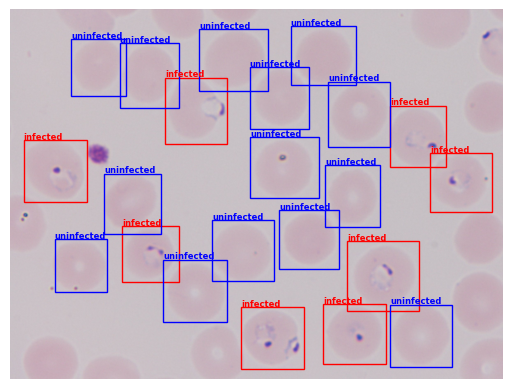

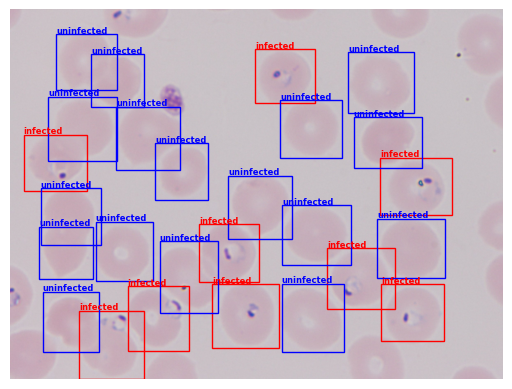

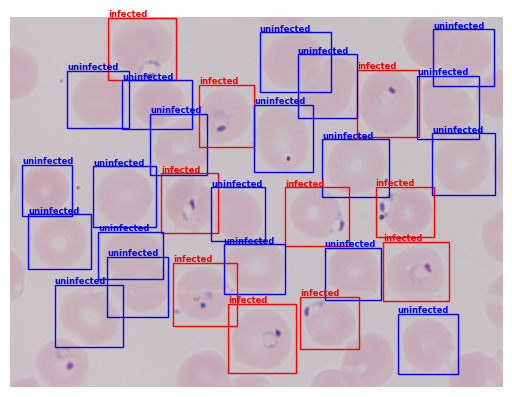

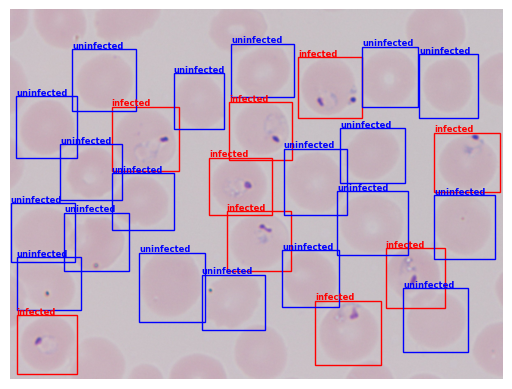

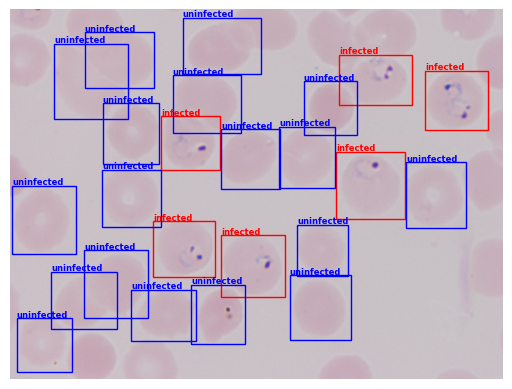

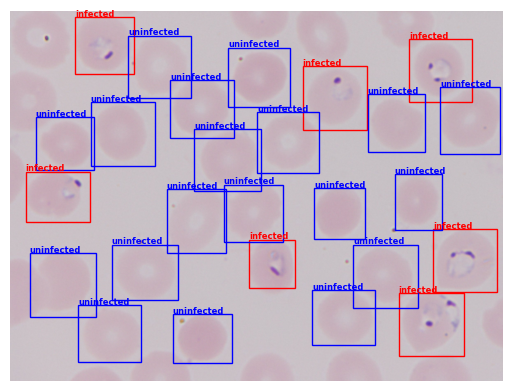

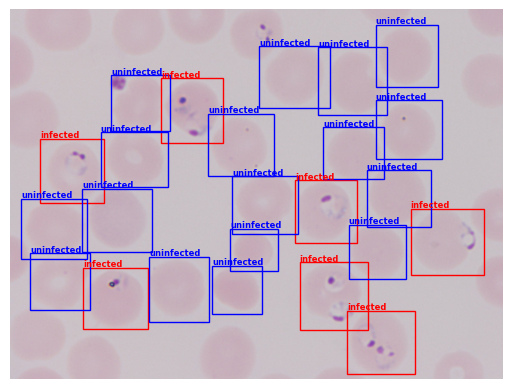

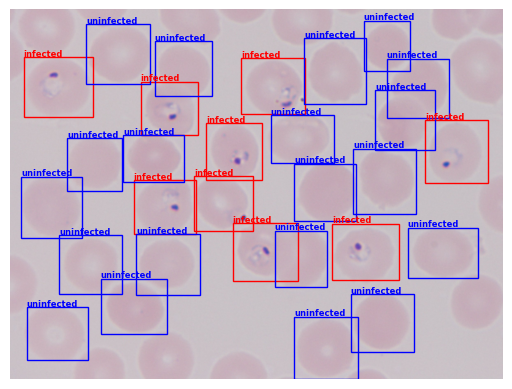

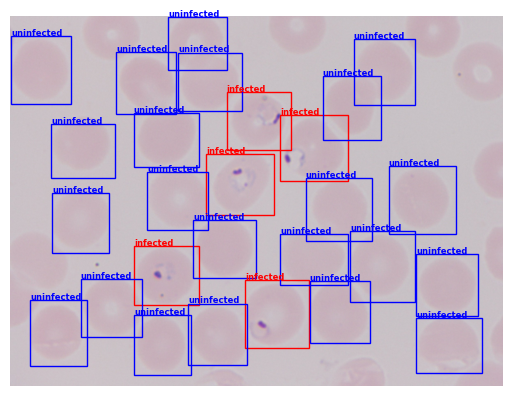

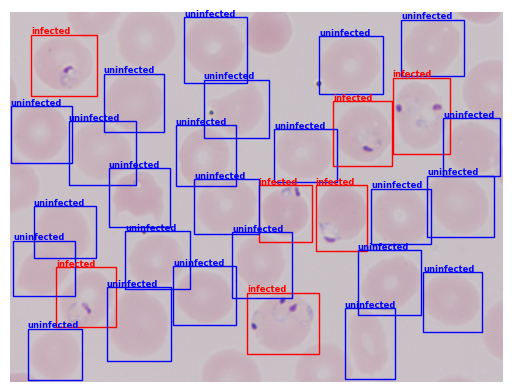

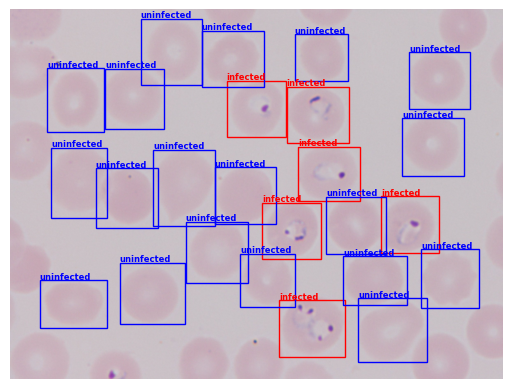

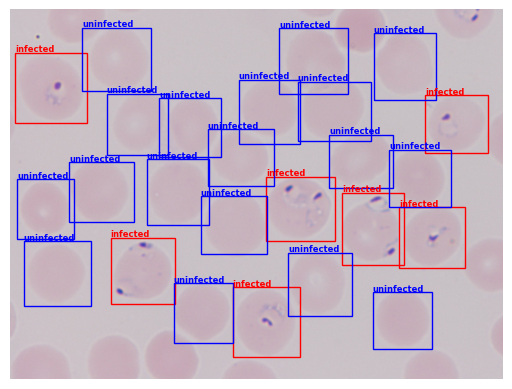

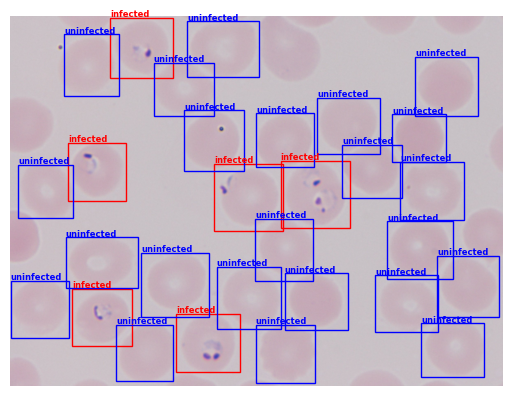

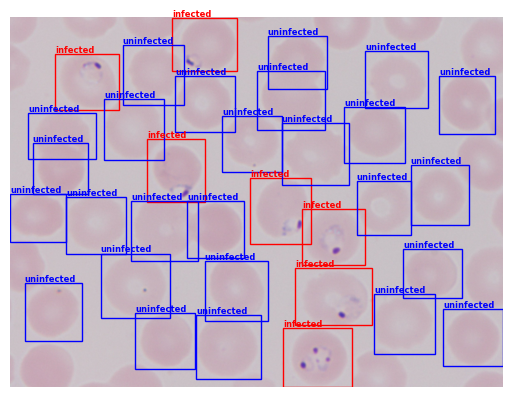

In [ ]:
# Get image IDs
ids_images = coco.getImgIds()

# View some images and their annotations
num_images_show = 10

for id_image in ids_images[:num_images_show]:

    # Load image information and annotations
    info_image = coco.loadImgs(id_image)[0]
    annotations_ids = coco.getAnnIds(imgIds=id_image)
    annotations = coco.loadAnns(annotations_ids)

    # Read and show the image
    path_image = directory_images + info_image['file_name']
    image = Image.open(path_image)
    plt.imshow(image)
    plt.axis('off')

    # Draw the bounding boxes and label them on the image
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        color = category_colors.get(category_name)

        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert from (x, y, w, h) to (x_min, y_min, x_max, y_max)
        rect = patches.Rectangle((bbox[0], bbox[1]), (bbox[2]-bbox[0]), (bbox[3]-bbox[1]), linewidth=1, edgecolor= color, facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(bbox[0], bbox[1]-5, category_name, color=color, fontsize=6, weight='bold')

    plt.show()

# Segment Anything Model

**SAM model installation**

In [ ]:
# Install SAM
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
# Download SAM weights
home = os.getcwd()
!mkdir -p {home}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {home}/weights

checkpoint_path = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")
print(checkpoint_path, "; exist:", os.path.isfile(checkpoint_path))

In [ ]:
# Load SAM
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
mask_predictor = SamPredictor(sam)

**Images segmentation**

In [ ]:
num_images_show = 331

for id_image in ids_images[:num_images_show]:

    # Load image information and annotations
    info_image = coco.loadImgs(id_image)[0]
    anotations_ids = coco.getAnnIds(imgIds=id_image)
    annotations = coco.loadAnns(anotations_ids)

    # Path of the image
    path_image = directory_images + info_image['file_name']

    # Convert BGR to RGB
    image_bgr = cv2.imread(path_image)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Obtain the bounding boxes
    for ann in annotations:
        bbox = ann['bbox']
        # The bounding box format for the SAM model should be in the form of [x_min, y_min, x_max, y_max]
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert from [x, y, w, h] to [x_min, y_min, x_max, y_max]
        bbox = np.array(bbox)

        # Category of the cell
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']

        # Set name of images as 'patient_01_01_num_category' to save orderly
        image_name_save = info_image['file_name']
        image_name_save = image_name_save.replace(".jpg", "") # remove .jpg extension
        image_name_save = image_name_save[9:] # remove image name from the beggining
        image_name_save = image_name_save + '_' + str(ann['id']) + '_' + category_name # add annotation id and category
        print(image_name_save)

        # Segmentation with Bounding Box
        mask_predictor.set_image(image_rgb)
        masks, scores, logits = mask_predictor.predict(box=bbox, multimask_output=True) # use multimask_output=True to obtain 3 masks

        for i, (mask, score) in enumerate(zip(masks, scores)):
            mask = masks[np.argmax(scores)].astype(int) # from the three masks, choose the best mask (the one with highest score)

        mask_trans = np.moveaxis(mask, 0, 1) # change channels first (channel, width, height) to channels last format (width, height, channel)
        mask_image = (mask * 255).astype(np.uint8) # Convert to uint8 format
        #directory_save_masks = '/content/drive/MyDrive/data/best_masks/'
        #cv2.imwrite(os.path.join(directory_save_masks, image_name_save + '_mask.jpg'), mask_image) # save masks

        # Obtain and save masked images
        masked_image = cv2.bitwise_and(image_bgr, image_bgr, mask=mask_image)
        #directory_save_masked_images = '/content/drive/MyDrive/data/masked_images/'
        #cv2.imwrite(os.path.join(directory_save_masked_images, image_name_save + '_masked.jpg'), masked_image) # save masked images

        # Crop RBC and save cell images
        (x, y, w, h) = cv2.boundingRect(mask_image) # Get coordinates of minimum enclosing rectangle
        cell_image = masked_image[y:y+h, x:x+w] # Crop image to object area
        directory_save_cell_images = '/content/drive/MyDrive/data/cell_images/'
        cv2.imwrite(os.path.join(directory_save_cell_images, image_name_save + '_RBC.jpg'), cell_image) # save cut RBC images

**Count the number of images**

In [ ]:
# Count the number of total images of RBC in the folder 'cell_images'
total_files = os.listdir('/content/drive/MyDrive/data/cell_images/') #list of files in the folder
print(f"The number of files in the folder is: {len(total_files)}")

# Count the number of uninfected RBC
num_files_uninfected = sum(1 for file in total_files if 'uninfected' in file)
print(f"The number of uninfected RBC is: {num_files_uninfected}")

# Count the number of infected RBC
num_files_infected = sum(1 for file in total_files if '_infected' in file)
print(f"The number of infected RBC is: {num_files_infected}")

The number of files in the folder is: 8750
The number of uninfected RBC is: 7839
The number of infected RBC is: 911


**Images organization in two folders: infected and uninfected**

In [ ]:
# Copy the obtained images of infected and uninfected RBC in separated folders

# Directory where cell images are stored
directory_save_cell_images = '/content/drive/MyDrive/data/cell_images/'
total_files = os.listdir('/content/drive/MyDrive/data/cell_images/')

# Directories to copy 'infected' and 'uninfected' images
infected_directory = '/content/drive/MyDrive/data/infected_RBC/'
uninfected_directory = '/content/drive/MyDrive/data/uninfected_RBC/'

# Iterate over each file and check if the name contains the word 'infected' or 'uninfected' and copy to the folder
for file in total_files:
    if '_infected' in file: # Check if the file name contains the word 'infected'
        shutil.copy(os.path.join(directory_save_cell_images, file), infected_directory) # Copy the file to the 'infected' directory
    elif '_uninfected' in file: # Check if the file name contains the word 'uninfected'
        shutil.copy(os.path.join(directory_save_cell_images, file), uninfected_directory) # Copy the file to the 'uninfected' directory

In [ ]:
# Count the number of total images in the folder 'infected_RBC' and 'uninfected_RBC'
total_files_infected = os.listdir('/content/drive/MyDrive/data/infected_RBC/') #list of files in the folder 'infected_RBC'
print(f"Number of files in the folder 'infected_RBC': {len(total_files_infected)}")

total_files_uninfected = os.listdir('/content/drive/MyDrive/data/uninfected_RBC/') #list of files in the folder 'uninfected_RBC'
print(f"Number of files in the folder 'uninfected_RBC': {len(total_files_uninfected)}")

Number of files in the folder 'infected_RBC': 902
Number of files in the folder 'uninfected_RBC': 7838


# Features extraction

Comparison of thresholds to obtain binary images - save images to create a figure for the report

In [ ]:
# Input and output directories
input_folder = '/content/drive/MyDrive/data/infected_RBC/'
output_folder_base = '/content/drive/MyDrive/data/binary_comparison/'

# Thresholds
thresholds = [50, 60, 70, 80, 90, 128]

# Output folders for each threshold
output_folders = [f'{output_folder_base}_threshold_{threshold}' for threshold in thresholds]
for folder in output_folders:
    os.makedirs(folder, exist_ok=True)

# Obtain binary images
for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        # Read the input image
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply different thresholds and save binary images
        for threshold, output_folder in zip(thresholds, output_folders):
            _, binary_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, binary_image)

Visualize images in R, G and B, grayscale and binarized

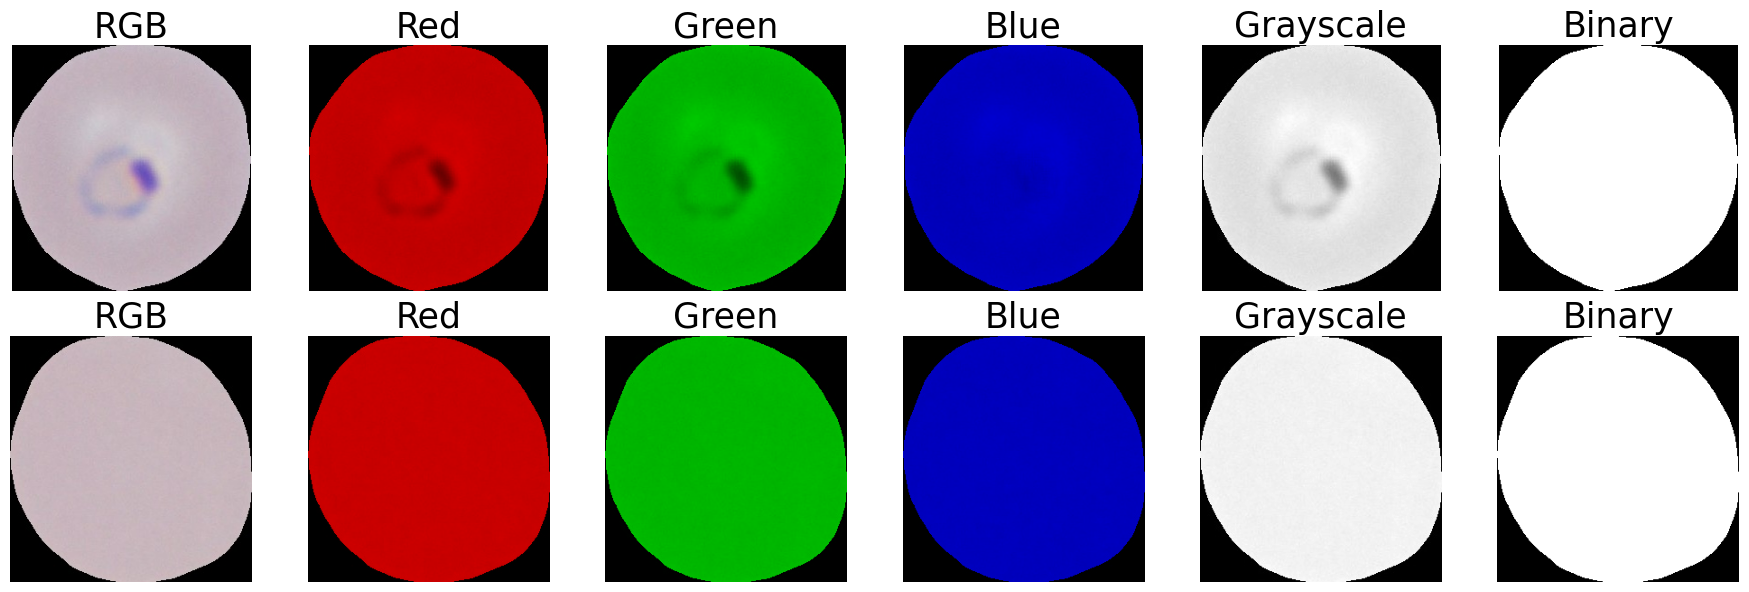

In [ ]:
# Paths to the two images
image_path1 = '/content/drive/MyDrive/data/infected_RBC/patient_04_94_8191_infected_RBC.jpg'  # Path to infected image (example)
image_path2 = '/content/drive/MyDrive/data/uninfected_RBC/patient_05_17_8748_uninfected_RBC.jpg'  # Path to uninfected image (example)

# Function to process and display an image
def process_and_display_image(image_path, row_offset=0):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image in RGB
    plt.subplot(2, 6, 1 + row_offset)
    plt.imshow(image_rgb)
    plt.title('RGB', fontsize=25)
    plt.axis('off')

    # Display the Red, Green, and Blue components
    R = image_rgb.copy()
    R[:, :, 1] = 0
    R[:, :, 2] = 0

    G = image_rgb.copy()
    G[:, :, 0] = 0
    G[:, :, 2] = 0

    B = image_rgb.copy()
    B[:, :, 0] = 0
    B[:, :, 1] = 0

    plt.subplot(2, 6, 2 + row_offset)
    plt.imshow(R)
    plt.title('Red', fontsize=25)
    plt.axis('off')

    plt.subplot(2, 6, 3 + row_offset)
    plt.imshow(G)
    plt.title('Green', fontsize=25)
    plt.axis('off')

    plt.subplot(2, 6, 4 + row_offset)
    plt.imshow(B)
    plt.title('Blue', fontsize=25)
    plt.axis('off')

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.subplot(2, 6, 5 + row_offset)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale', fontsize=25)
    plt.axis('off')

    # Binarize the image using a threshold
    _, binary_image = cv2.threshold(gray_image, 60, 255, cv2.THRESH_BINARY) #60 to not include the parasite in infected images

    plt.subplot(2, 6, 6 + row_offset)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary', fontsize=25)
    plt.axis('off')

# Create a plot to show both images
plt.figure(figsize=(18, 6))

# Process and display the first image
process_and_display_image(image_path1, row_offset=0)

# Process and display the second image
process_and_display_image(image_path2, row_offset=6)

plt.tight_layout()
plt.show()

Example of histograms to create a figure for the report

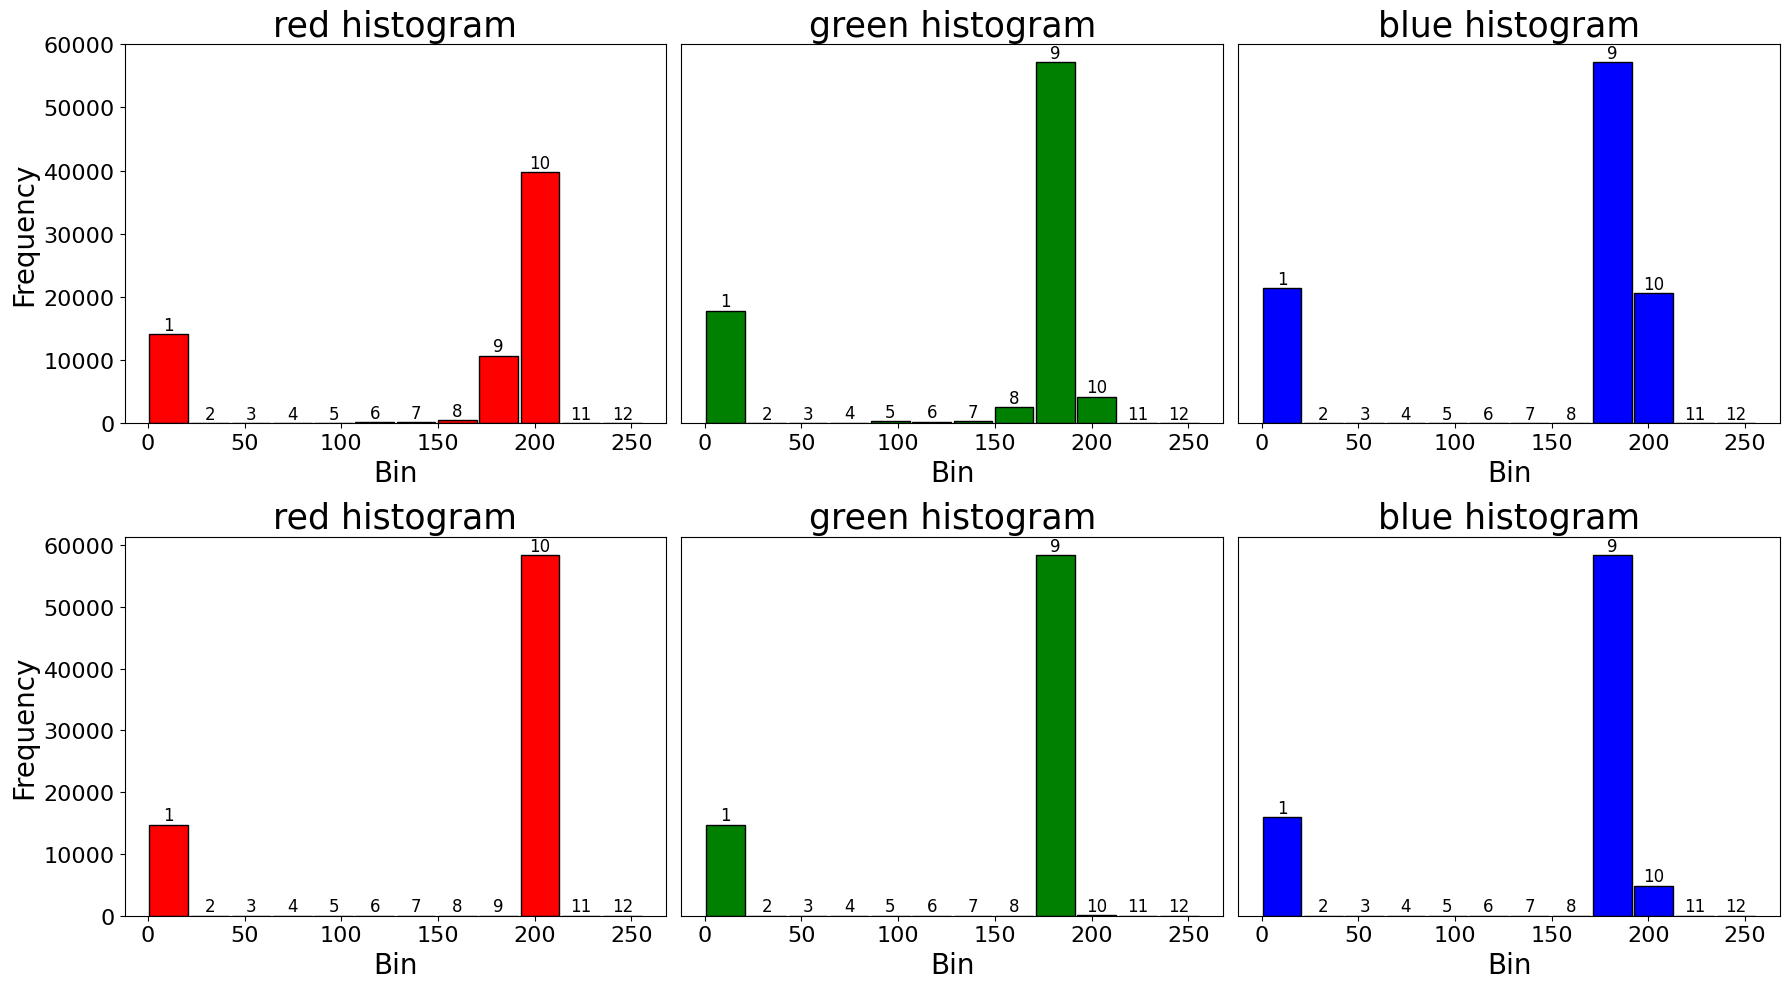

In [ ]:
# Paths to the two images
image_path_infected = '/content/drive/MyDrive/data/infected_RBC/patient_04_94_8191_infected_RBC.jpg'  # Path to infected image (example)
image_path_uninfected = '/content/drive/MyDrive/data/uninfected_RBC/patient_05_17_8748_uninfected_RBC.jpg'  # Path to uninfected image (example)

# Function to obtain histograms
def compute_and_display_histograms(image_path, row_offset=0):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Separate the R, G, B channels
    R, G, B = image_rgb[:,:,0], image_rgb[:,:,1], image_rgb[:,:,2]

    # Histograms for R, G, and B channels with 12 bins in the range [0, 256]
    channels = [R, G, B]
    colors = ['red', 'green', 'blue']

    for i, (channel, color) in enumerate(zip(channels, colors)):
        hist, bins = np.histogram(channel, bins=12, range=(0, 256))
        center = (bins[:-1] + bins[1:]) / 2
        plt.subplot(2, 3, i + 1 + row_offset)
        plt.bar(center, hist, width=20, color=color, edgecolor='black')
        plt.title(f'{color} histogram', fontsize=25)
        plt.xlabel('Bin', fontsize=20)
        plt.xticks(fontsize=16)
        if color == 'red':  # Show labels on y-axis only for red histogram
            plt.ylabel('Frequency', fontsize=20)
            plt.yticks(np.arange(0, 60001, 10000), fontsize=16)
        else:
            plt.yticks([])
        for x, y, bin_number in zip(center, hist, range(1, 13)):
            plt.text(x, y + 50, str(bin_number), ha='center', va='bottom', fontsize=12)  # Add bin numbers at the top of bars

# Plot to show histograms for both images
plt.figure(figsize=(18, 10))

# Histograms for the infected image
compute_and_display_histograms(image_path_infected, row_offset=0)

# Histograms for the uninfected image
compute_and_display_histograms(image_path_uninfected, row_offset=3)

plt.tight_layout()
plt.show()

**Features extraction**

In [ ]:
# Paths to the folders containing the images
folder_path_infected = '/content/drive/MyDrive/data/infected_RBC/'
folder_path_uninfected = '/content/drive/MyDrive/data/uninfected_RBC/'

# Lists to store values and labels
infected_features = []
infected_labels = []

uninfected_features = []
uninfected_labels = []

# Lists to store paths of images
infected_paths = []
uninfected_paths = []

# List with the features names
feature_names = ['mean_red', 'std_red', 'kurtosis_red', 'skewness_red', 'entropy_red',
                 'hist_1_red', 'hist_2_red', 'hist_3_red', 'hist_4_red', 'hist_5_red', 'hist_6_red', 'hist_7_red', 'hist_8_red','hist_9_red', 'hist_10_red', 'hist_11_red', 'hist_12_red',
                 'mean_green', 'std_green', 'kurtosis_green', 'skewness_green', 'entropy_green',
                 'hist_1_green', 'hist_2_green', 'hist_3_green', 'hist_4_green', 'hist_5_green', 'hist_6_green', 'hist_7_green', 'hist_8_green','hist_9_green', 'hist_10_green', 'hist_11_green', 'hist_12_green',
                 'mean_blue', 'std_blue', 'kurtosis_blue', 'skewness_blue', 'entropy_blue',
                 'hist_1_blue', 'hist_2_blue', 'hist_3_blue', 'hist_4_blue', 'hist_5_blue', 'hist_6_blue', 'hist_7_blue', 'hist_8_blue','hist_9_blue', 'hist_10_blue', 'hist_11_blue', 'hist_12_blue',
                 'mean_gray', 'std_gray', 'kurtosis_gray', 'skewness_gray', 'entropy_gray',
                 'contrast_gray', 'correlation_gray', 'energy_gray', 'dissimilarity_gray', 'homogeneity_gray',
                 'contrast_red', 'correlation_red', 'energy_red', 'dissimilarity_red', 'homogeneity_red',
                 'contrast_green', 'correlation_green', 'energy_green', 'dissimilarity_green', 'homogeneity_green', 'contrast_blue',
                 'correlation_blue', 'energy_blue', 'dissimilarity_blue', 'homogeneity_blue',
                 'area', 'perimeter', 'circularity', 'eccentricity']

# Loop through the images in the infected folder
for filename in os.listdir(folder_path_infected):
    image_RBC = io.imread(os.path.join(folder_path_infected, filename)) # read the image
    image_path = os.path.join(folder_path_infected, filename)
    infected_paths.append(image_path) # save each image path in a list
    infected_labels.append('1')

    # List to include features values
    features = []

    # 1. COLOUR FEATURES (RGB image)
    for channel in range(3):  # Iterate over RGB channels
        channel_data = image_RBC[:, :, channel].ravel()
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        kurtosis_value = kurtosis(channel_data)
        skewness = skew(channel_data)
        entropy = shannon_entropy(channel_data)
        hist, _ = np.histogram(channel_data, bins=12, range=(0, 256))

        features.extend([mean, std, kurtosis_value, skewness, entropy])
        features.extend(hist)

    # 2. TEXTURE FEATURES (gray image)
    gray_image_RBC = cv2.cvtColor(image_RBC, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
    gray_image_RBC_flattened = gray_image_RBC.flatten()
    mean_gray = np.mean(gray_image_RBC)
    std_gray = np.std(gray_image_RBC)
    kurtosis_gray = kurtosis(gray_image_RBC_flattened)
    skewness_gray = skew(gray_image_RBC_flattened)
    entropy_gray = shannon_entropy(gray_image_RBC)

    # GLCM features (gray image)
    glcm_gray = greycomatrix(gray_image_RBC, distances=[1], angles=[0], levels=256, symmetric=True, normed=True) # Calculate GLCM
    contrast_gray = greycoprops(glcm_gray, 'contrast')[0, 0]
    correlation_gray = greycoprops(glcm_gray, 'correlation')[0, 0]
    energy_gray = greycoprops(glcm_gray, 'energy')[0, 0]
    dissimilarity_gray = greycoprops(glcm_gray, 'dissimilarity')[0, 0]
    homogeneity_gray = greycoprops(glcm_gray, 'homogeneity')[0, 0]

    features.extend([mean_gray, std_gray, kurtosis_gray, skewness_gray, entropy_gray, contrast_gray, correlation_gray, energy_gray, dissimilarity_gray, homogeneity_gray])

    # GLCM features (RGB image)
      # Red channel
    glcm_red_channel= greycomatrix(image_RBC[:, :, 0], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_red = greycoprops(glcm_red_channel, 'contrast')[0, 0]
    correlation_red = greycoprops(glcm_red_channel, 'correlation')[0, 0]
    energy_red = greycoprops(glcm_red_channel, 'energy')[0, 0]
    dissimilarity_red = greycoprops(glcm_red_channel, 'dissimilarity')[0, 0]
    homogeneity_red = greycoprops(glcm_red_channel, 'homogeneity')[0, 0]

    features.extend([contrast_red, correlation_red, energy_red, dissimilarity_red, homogeneity_red])

      # Green channel
    glcm_green_channel= greycomatrix(image_RBC[:, :, 1], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_green = greycoprops(glcm_green_channel, 'contrast')[0, 0]
    correlation_green = greycoprops(glcm_green_channel, 'correlation')[0, 0]
    energy_green = greycoprops(glcm_green_channel, 'energy')[0, 0]
    dissimilarity_green = greycoprops(glcm_green_channel, 'dissimilarity')[0, 0]
    homogeneity_green = greycoprops(glcm_green_channel, 'homogeneity')[0, 0]

    features.extend([contrast_green, correlation_green, energy_green, dissimilarity_green, homogeneity_green])

        # Blue channel
    glcm_blue_channel= greycomatrix(image_RBC[:, :, 2], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_blue = greycoprops(glcm_blue_channel, 'contrast')[0, 0]
    correlation_blue = greycoprops(glcm_blue_channel, 'correlation')[0, 0]
    energy_blue = greycoprops(glcm_blue_channel, 'energy')[0, 0]
    dissimilarity_blue = greycoprops(glcm_blue_channel, 'dissimilarity')[0, 0]
    homogeneity_blue = greycoprops(glcm_blue_channel, 'homogeneity')[0, 0]

    features.extend([contrast_blue, correlation_blue, energy_blue, dissimilarity_blue, homogeneity_blue])

    # 3. GEOMETRIC FEATURES (binary image)
    _, binary_image_RBC = cv2.threshold(gray_image_RBC, 60, 255, cv2.THRESH_BINARY) # Apply thresholding to obtain binary image

    labeled_image = measure.label(binary_image_RBC) # Label connected components
    regions = measure.regionprops(labeled_image) # Calculate region properties
    region = max(regions, key=lambda r: r.area) # Assuming the largest region is the object of interest

    # Calculate properties
    area = region.area
    perimeter = region.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = region.eccentricity

    features.extend([area, perimeter, circularity, eccentricity])

    infected_features.append(features)


# Loop through the images in the uninfected folder
for filename in os.listdir(folder_path_uninfected):
    image_RBC = io.imread(os.path.join(folder_path_uninfected, filename)) # read the image
    image_path = os.path.join(folder_path_uninfected, filename)
    uninfected_paths.append(image_path) # save each image path in a list
    uninfected_labels.append('0')

    # List to include features values
    features = []

    # 1. COLOUR FEATURES (RGB image)
    for channel in range(3):  # Iterate over RGB channels
        channel_data = image_RBC[:, :, channel].ravel()
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        kurtosis_value = kurtosis(channel_data)
        skewness = skew(channel_data)
        entropy = shannon_entropy(channel_data)
        hist, _ = np.histogram(channel_data, bins=12, range=(0, 256))

        features.extend([mean, std, kurtosis_value, skewness, entropy])
        features.extend(hist)

    # 2. TEXTURE FEATURES (gray image)
    gray_image_RBC = cv2.cvtColor(image_RBC, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
    gray_image_RBC_flattened = gray_image_RBC.flatten()
    mean_gray = np.mean(gray_image_RBC)
    std_gray = np.std(gray_image_RBC)
    kurtosis_gray = kurtosis(gray_image_RBC_flattened)
    skewness_gray = skew(gray_image_RBC_flattened)
    entropy_gray = shannon_entropy(gray_image_RBC)

    # GLCM features (gray image)
    glcm_gray = greycomatrix(gray_image_RBC, distances=[1], angles=[0], levels=256, symmetric=True, normed=True) # Calculate GLCM
    contrast_gray = greycoprops(glcm_gray, 'contrast')[0, 0]
    correlation_gray = greycoprops(glcm_gray, 'correlation')[0, 0]
    energy_gray = greycoprops(glcm_gray, 'energy')[0, 0]
    dissimilarity_gray = greycoprops(glcm_gray, 'dissimilarity')[0, 0]
    homogeneity_gray = greycoprops(glcm_gray, 'homogeneity')[0, 0]

    features.extend([mean_gray, std_gray, kurtosis_gray, skewness_gray, entropy_gray, contrast_gray, correlation_gray, energy_gray, dissimilarity_gray, homogeneity_gray])

    # GLCM features (RGB image)
      # Red channel
    glcm_red_channel= greycomatrix(image_RBC[:, :, 0], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_red = greycoprops(glcm_red_channel, 'contrast')[0, 0]
    correlation_red = greycoprops(glcm_red_channel, 'correlation')[0, 0]
    energy_red = greycoprops(glcm_red_channel, 'energy')[0, 0]
    dissimilarity_red = greycoprops(glcm_red_channel, 'dissimilarity')[0, 0]
    homogeneity_red = greycoprops(glcm_red_channel, 'homogeneity')[0, 0]

    features.extend([contrast_red, correlation_red, energy_red, dissimilarity_red, homogeneity_red])

      # Green channel
    glcm_green_channel= greycomatrix(image_RBC[:, :, 1], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_green = greycoprops(glcm_green_channel, 'contrast')[0, 0]
    correlation_green = greycoprops(glcm_green_channel, 'correlation')[0, 0]
    energy_green = greycoprops(glcm_green_channel, 'energy')[0, 0]
    dissimilarity_green = greycoprops(glcm_green_channel, 'dissimilarity')[0, 0]
    homogeneity_green = greycoprops(glcm_green_channel, 'homogeneity')[0, 0]

    features.extend([contrast_green, correlation_green, energy_green, dissimilarity_green, homogeneity_green])

      # Blue channel
    glcm_blue_channel= greycomatrix(image_RBC[:, :, 2], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast_blue = greycoprops(glcm_blue_channel, 'contrast')[0, 0]
    correlation_blue = greycoprops(glcm_blue_channel, 'correlation')[0, 0]
    energy_blue = greycoprops(glcm_blue_channel, 'energy')[0, 0]
    dissimilarity_blue = greycoprops(glcm_blue_channel, 'dissimilarity')[0, 0]
    homogeneity_blue = greycoprops(glcm_blue_channel, 'homogeneity')[0, 0]

    features.extend([contrast_blue, correlation_blue, energy_blue, dissimilarity_blue, homogeneity_blue])

    # 3. GEOMETRIC FEATURES (binary image)
    _, binary_image_RBC = cv2.threshold(gray_image_RBC, 60, 255, cv2.THRESH_BINARY) # Apply thresholding to obtain binary image

    labeled_image = measure.label(binary_image_RBC) # Label connected components
    regions = measure.regionprops(labeled_image) # Calculate region properties
    region = max(regions, key=lambda r: r.area) # Assuming the largest region is the object of interest

    # Calculate properties
    area = region.area
    perimeter = region.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = region.eccentricity

    features.extend([area, perimeter, circularity, eccentricity])

    uninfected_features.append(features)


# Combine features and labels
X = np.vstack((infected_features, uninfected_features))
y = np.concatenate((infected_labels, uninfected_labels))

# Combine paths
image_paths = np.concatenate((infected_paths, uninfected_paths))

In [ ]:
print(type(features))
print(len(features))

In [ ]:
# Check type and shape of X, y and image_paths
print(type(X))
print(type(y))
print(type(image_paths))

print(X.shape)
print(len(y))
print(len(image_paths))

# Change y and image_paths to list
y = y.tolist()
image_paths = image_paths.tolist()
print(type(y))
print(type(image_paths))

**Save feature data in an excel**

In [ ]:
# Convert numpy array 'X' to a pandas DataFrame
X_df = pd.DataFrame(X)

# DataFrame for 'y' and 'image_paths'
y_image_paths = pd.DataFrame({'y': y, 'image_paths': image_paths})

# Concatenate X, y and image_paths in the same dataframe
data = pd.concat([X_df, y_image_paths], axis=1)

In [ ]:
# Save excel in Google drive
excel_filename = 'features_data.xlsx' # file name
data.to_excel(excel_filename, index=False)
excel_path = ('/content/drive/MyDrive/data/') # path to save the file
shutil.move(excel_filename, excel_path + excel_filename) # Move the file to the path

# Classification model

**Classification model: Random Forest with cross-validation**

In [ ]:
# Load the dataset with features
# Replace 'path_to_dataset.csv' with your actual dataset path
data = pd.read_excel('/content/drive/MyDrive/data/features_data.xlsx')

In [ ]:
# Extract features, labels, and image paths from the dataset
feature_columns = [col for col in data.columns if col not in ['y', 'image_paths']]
X = data.drop(['y', 'image_paths'], axis=1).values
y = data['y']
image_paths = data['image_paths'].values

**Resampling**

Perform a subsampling where the minority class (infected) has approximately 30% of the number of samples of the majority class (uninfected)

In [ ]:
# Remove data from X, y and image_paths

# Set seed to obtain the same result in every execution of the code
np.random.seed(42)

# Count the number of samples before subsampling

total_uninfected_samples = y.value_counts()[0]
total_infected_samples = y.value_counts()[1]
print("Number of uninfected samples initial:", total_uninfected_samples)
print("% uninfected samples initial:", total_uninfected_samples/(total_uninfected_samples + total_infected_samples)*100)
print("Number of infected samples initial:", total_infected_samples)
print("% infected samples initial:", total_infected_samples/(total_uninfected_samples + total_infected_samples)*100)

# Calculate the number of samples you need to remove from the uninfected group so that the infected group represents 30% of the data
percentage_infected_objective = 0.3 # 30%
uninfected_to_remove = total_uninfected_samples - (int((1 - percentage_infected_objective) * total_infected_samples / percentage_infected_objective))
print("Number of uninfected samples to remove:", uninfected_to_remove)

# Identify the positions of the uninfected group samples
index_uninfected = [index for index, value in enumerate(y) if value == 0]

# Randomly select samples from the uninfected group to eliminate them
index_to_remove = np.random.choice(index_uninfected, size=uninfected_to_remove, replace=False)

# Remove selected samples from training data set
y_resampled = np.delete(y, index_to_remove)
X_resampled= np.delete(X, index_to_remove, axis=0)
image_paths_resampled=np.delete(image_paths, index_to_remove)

# Count the number of samples after subsampling
total_uninfected_samples_resampled = sum(y_resampled == 0)
total_infected_samples_resampled = sum(y_resampled == 1)

print("Number of uninfected samples:", total_uninfected_samples_resampled)
print("% uninfected samples after resampling:", total_uninfected_samples_resampled/(total_uninfected_samples_resampled + total_infected_samples_resampled)*100)
print("Number of infected samples after resampling:", total_infected_samples_resampled)
print("% infected samples after resampling:", total_infected_samples_resampled/(total_uninfected_samples_resampled + total_infected_samples_resampled)*100)

# Shape of dataset of features
shape_resampled = X_resampled.shape
print(shape_resampled)

Number of uninfected samples initial: 7700
% uninfected samples initial: 89.5244738983839
Number of infected samples initial: 901
% infected samples initial: 10.47552610161609
Number of uninfected samples to remove: 5598
Number of uninfected samples: 2102
% uninfected samples after resampling: 69.99666999667
Number of infected samples after resampling: 901
% infected samples after resampling: 30.003330003330003
(3003, 80)


In [ ]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Obtain cross-validated predictions
model = BalancedRandomForestClassifier(random_state=42)
y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=cv)

In [ ]:
# Calculate confusion matrix components
TN, FP, FN, TP = confusion_matrix(y_resampled, y_pred).ravel()
print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)

# Accuracy
accuracy = accuracy_score(y_resampled, y_pred)

# Precision
precision = precision_score(y_resampled, y_pred, pos_label=1)

# Recall
recall = recall_score(y_resampled, y_pred, pos_label=1)

# F1-score
f1 = f1_score(y_resampled, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

True Positives: 896
False Positives: 10
True Negatives: 2092
False Negatives: 5
Accuracy: 0.995
Precision: 0.989
Recall: 0.994
F1-score: 0.992


In [ ]:
# Misclassified images
misclassified_indices = np.where(y_resampled != y_pred)[0]
misclassified_images = image_paths[misclassified_indices]

# Print misclassified images
for index in misclassified_indices:
    print(f'Predicted: {y_pred[index]}, Actual: {y_resampled[index]}')
    print(image_paths[index])
    io.imshow(image_paths[index])
    io.show()
    plt.axis('off')

# Feature importances

**Classification model for feature importances (80-20 split)**

In [ ]:
# Remove data from X, y and image_paths

# Set seed to obtain the same result in every execution of the code
np.random.seed(42)

# Count the number of samples before subsampling

total_uninfected_samples = y.value_counts()[0]
total_infected_samples = y.value_counts()[1]
print("Number of uninfected samples initial:", total_uninfected_samples)
print("% uninfected samples initial:", total_uninfected_samples/(total_uninfected_samples + total_infected_samples)*100)
print("Number of infected samples initial:", total_infected_samples)
print("% infected samples initial:", total_infected_samples/(total_uninfected_samples + total_infected_samples)*100)

# Calculate the number of samples you need to remove from the uninfected group so that the infected group represents 30% of the data
percentage_infected_objective = 0.3 # 30%
uninfected_to_remove = total_uninfected_samples - (int((1 - percentage_infected_objective) * total_infected_samples / percentage_infected_objective))
print("Number of uninfected samples to remove:", uninfected_to_remove)

# Identify the positions of the uninfected group samples
index_uninfected = [index for index, value in enumerate(y) if value == 0]

# Randomly select samples from the uninfected group to eliminate them
index_to_remove = np.random.choice(index_uninfected, size=uninfected_to_remove, replace=False)

# Remove selected samples from training data set
y_resampled = np.delete(y, index_to_remove)
X_resampled= np.delete(X, index_to_remove, axis=0)
image_paths_resampled=np.delete(image_paths, index_to_remove)

# Count the number of samples after subsampling
total_uninfected_samples_resampled = sum(y_resampled == 0)
total_infected_samples_resampled = sum(y_resampled == 1)

print("Number of uninfected samples:", total_uninfected_samples_resampled)
print("% uninfected samples after resampling:", total_uninfected_samples_resampled/(total_uninfected_samples_resampled + total_infected_samples_resampled)*100)
print("Number of infected samples after resampling:", total_infected_samples_resampled)
print("% infected samples after resampling:", total_infected_samples_resampled/(total_uninfected_samples_resampled + total_infected_samples_resampled)*100)

# Shape of dataset of features
shape_resampled = X_resampled.shape
print(shape_resampled)

Number of uninfected samples initial: 7700
% uninfected samples initial: 89.5244738983839
Number of infected samples initial: 901
% infected samples initial: 10.47552610161609
Number of uninfected samples to remove: 5598
Number of uninfected samples: 2102
% uninfected samples after resampling: 69.99666999667
Number of infected samples after resampling: 901
% infected samples after resampling: 30.003330003330003
(3003, 80)


In [ ]:
# Split data into train and test sets

X_train, X_test, y_train, y_test, image_paths_train, image_paths_test = train_test_split(X_resampled, y_resampled, image_paths_resampled, test_size=0.2, random_state=42)

In [ ]:
# Model training

model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    # use the fixed value random_state=42 to obtain the same result in every execution of the code
model.fit(X_train, y_train)

In [ ]:
# Model evaluation

# Obtain predictions
y_pred = model.predict(X_test)

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(c_matrix)

# Extract TP, FP, TN, FN
TN, FP, FN, TP = c_matrix.ravel()
print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, pos_label=1)

# Recall
recall = recall_score(y_test, y_pred, pos_label=1)

# F1-score
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

In [ ]:
# Find misclassified images
misclassified_indices = np.where(model.predict(X_test) != y_test)[0]
print(misclassified_indices)

# Print misclassified images
for index in misclassified_indices:
    print(f"Index: {index}, Predicted: {y_pred[index]}, Actual: {y_test[index]}")
    print(image_paths_test[index])
    io.imshow(image_paths_test[index])
    io.show()
    plt.axis('off')

**A) Features importance**

Histogram with features importance

In [ ]:
feature_names = ['mean_red', 'std_red', 'kurtosis_red', 'skewness_red', 'entropy_red',
                 'hist_1_red', 'hist_2_red', 'hist_3_red', 'hist_4_red', 'hist_5_red', 'hist_6_red', 'hist_7_red', 'hist_8_red','hist_9_red', 'hist_10_red', 'hist_11_red', 'hist_12_red',
                 'mean_green', 'std_green', 'kurtosis_green', 'skewness_green', 'entropy_green',
                 'hist_1_green', 'hist_2_green', 'hist_3_green', 'hist_4_green', 'hist_5_green', 'hist_6_green', 'hist_7_green', 'hist_8_green','hist_9_green', 'hist_10_green', 'hist_11_green', 'hist_12_green',
                 'mean_blue', 'std_blue', 'kurtosis_blue', 'skewness_blue', 'entropy_blue',
                 'hist_1_blue', 'hist_2_blue', 'hist_3_blue', 'hist_4_blue', 'hist_5_blue', 'hist_6_blue', 'hist_7_blue', 'hist_8_blue','hist_9_blue', 'hist_10_blue', 'hist_11_blue', 'hist_12_blue',
                 'mean_gray', 'std_gray', 'kurtosis_gray', 'skewness_gray', 'entropy_gray',
                 'contrast_gray', 'correlation_gray', 'energy_gray', 'dissimilarity_gray', 'homogeneity_gray',
                 'contrast_red', 'correlation_red', 'energy_red', 'dissimilarity_red', 'homogeneity_red',
                 'contrast_green', 'correlation_green', 'energy_green', 'dissimilarity_green', 'homogeneity_green', 'contrast_blue',
                 'correlation_blue', 'energy_blue', 'dissimilarity_blue', 'homogeneity_blue',
                 'area', 'perimeter', 'circularity', 'eccentricity']

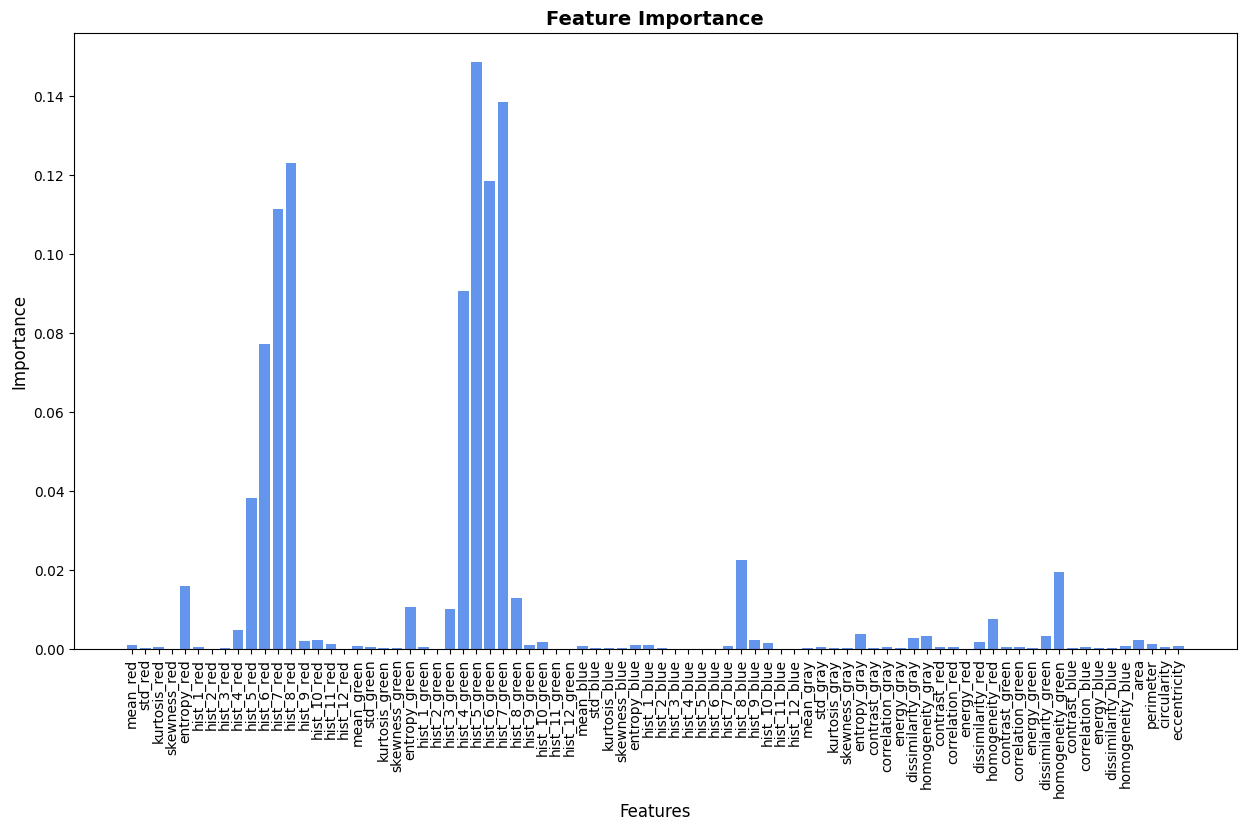

In [ ]:
# Calculate the importance of features
feature_importance = model.feature_importances_

# Create a dataframe with feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plot the most important features in a bar plot
plt.figure(figsize=(15, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='cornflowerblue')
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Importance', fontsize = 12)
plt.title('Feature Importance', fontsize = 14, fontweight="bold")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Sort the dataframe by feature importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(sorted_feature_importance_df.head(20))

                Feature  Importance
26         hist_5_green    0.148583
28         hist_7_green    0.138683
12           hist_8_red    0.123185
27         hist_6_green    0.118502
11           hist_7_red    0.111349
25         hist_4_green    0.090589
10           hist_6_red    0.077266
9            hist_5_red    0.038197
46          hist_8_blue    0.022534
70    homogeneity_green    0.019482
4           entropy_red    0.016014
29         hist_8_green    0.012947
21        entropy_green    0.010618
24         hist_3_green    0.010264
65      homogeneity_red    0.007649
8            hist_4_red    0.004824
55         entropy_gray    0.003834
60     homogeneity_gray    0.003412
69  dissimilarity_green    0.003203
59   dissimilarity_gray    0.002729


**B) SHAP values**

Calculate global SHAP for the entire test set and visualize using summary plot

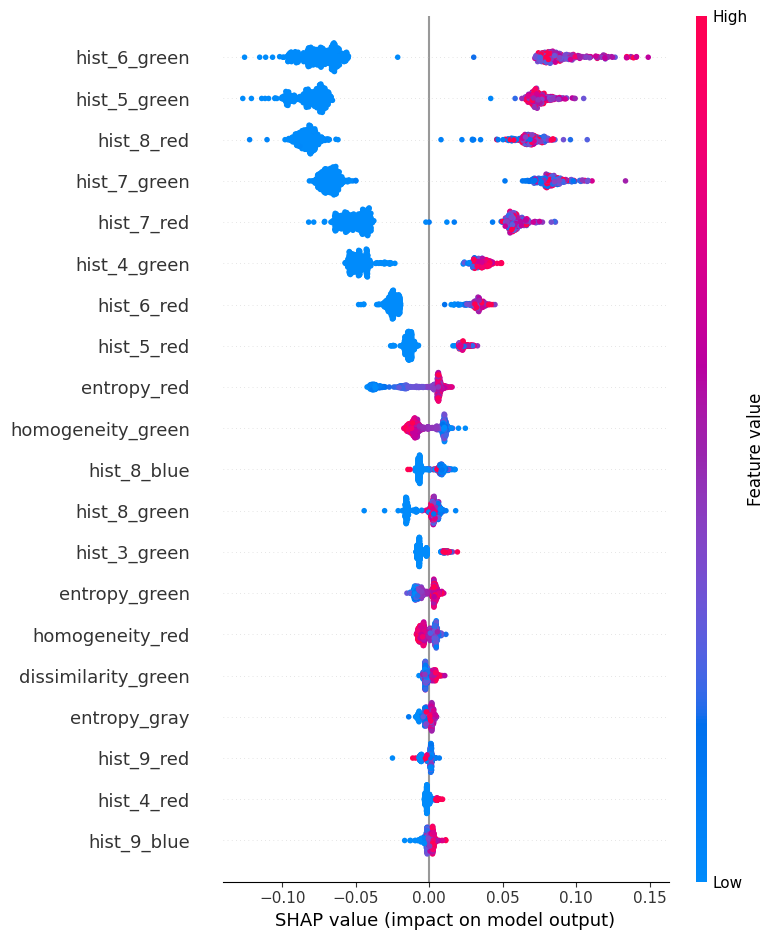

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for test images
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values[:,:,1], X_test, feature_names=feature_names)

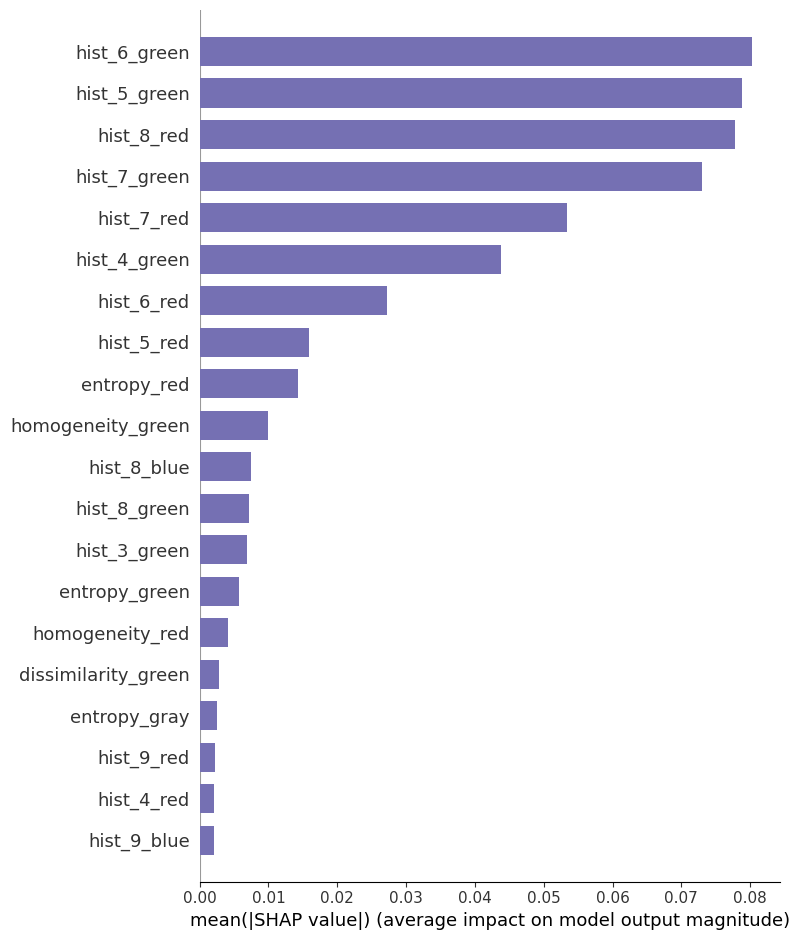

In [ ]:
# SHAP feature importance
cmap = plt.get_cmap("Dark2")
shap.summary_plot(shap_values[:,:,1], X_resampled, plot_type="bar", color=cmap.colors[2], feature_names=feature_names)

Separate global SHAP by class

In [ ]:
# Filter the dataset by class
X_test_class_0 = X_test[y_test == 0]
X_test_class_1 = X_test[y_test == 1]

# Calculate SHAP values for each class
shap_values_class_0 = explainer(X_test_class_0)
shap_values_class_1 = explainer(X_test_class_1)

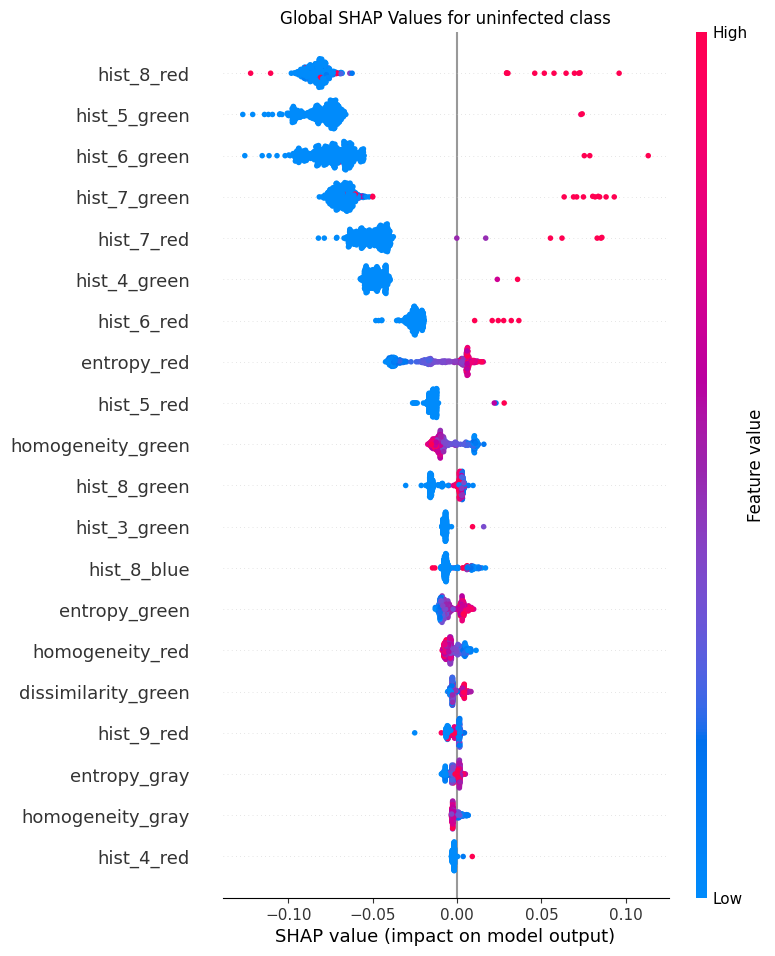

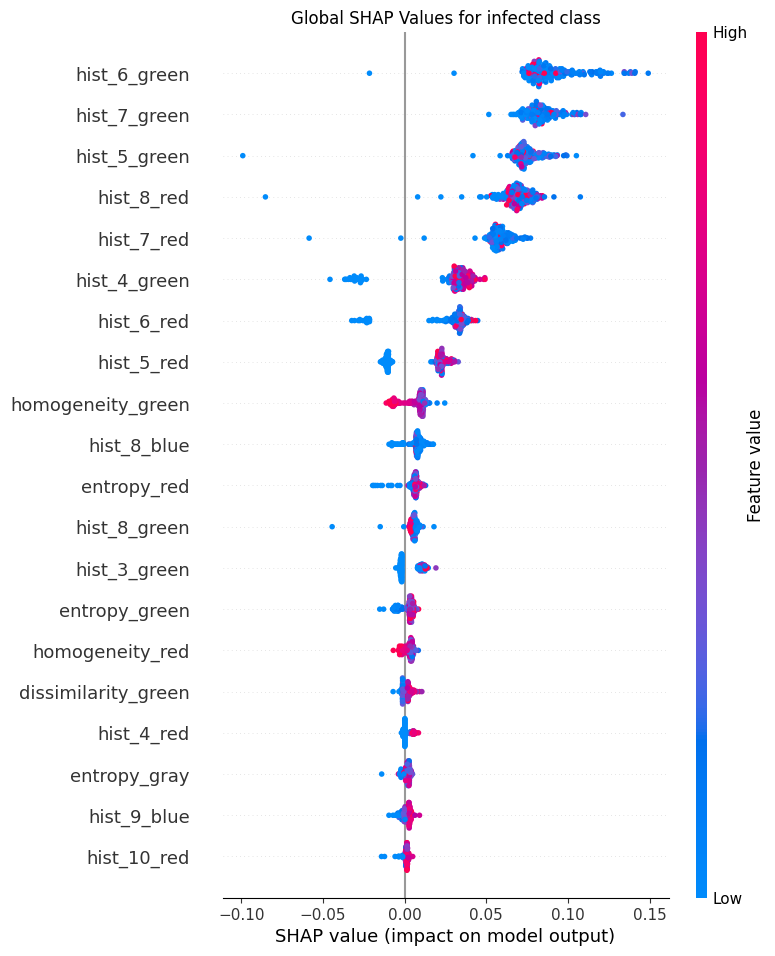

In [ ]:
# Generate summary plots for each class
shap.initjs()

# Summary plot for class 0 (uninfected)
shap.summary_plot(shap_values_class_0[:,:,1], X_test_class_0, feature_names=feature_names, show=False)
plt.title("Global SHAP Values for uninfected class")
plt.show()

# Summary plot for class 1 (infected)
shap.summary_plot(shap_values_class_1[:,:,1], X_test_class_1, feature_names=feature_names, show=False)
plt.title("Global SHAP Values for infected class")
plt.show()

Calculate local SHAP

In [ ]:
X_test_pd = pd.DataFrame(X_test)
y_test_pd = pd.DataFrame(y_test)
image_paths_test_pd = pd.DataFrame(image_paths_test)

In [ ]:
# Choose one instance from the dataset (select by one by changing the number)

instance_index = 15  # Choose the index of the instance
X_instance = X_test_pd.iloc[[instance_index]]  # Select the instance from the dataset

y_instance = y_test_pd.iloc[[instance_index]]
print('Class:', y_instance)

# Temporarily set pandas display options to show full image path
pd.set_option('display.max_colwidth', None)

image_path_instance = image_paths_test_pd.iloc[[instance_index]]
print(image_path_instance)

# Initialize SHAP explainer with the trained model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the chosen instance
shap_values = explainer.shap_values(X_instance)
shap_values = shap_values[:,:,1]

# Visualize the SHAP force plot
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values, X_instance, feature_names=feature_names)

Class:     0
15  1
                                                                               0
15  /content/drive/MyDrive/data/infected_RBC/patient_01_49_1312_infected_RBC.jpg


# Object detection

Load the dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/data/malaria_COCO/images/'
annotations_path = '/content/drive/MyDrive/data/malaria_COCO/result.json'

# Load annotations
coco = COCO(annotations_path)

# Get all image IDs
image_ids = coco.getImgIds()

# Custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Load image
        img_path = os.path.join(self.root, self.coco.imgs[img_id]['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Boundig boxes and labels
        boxes = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((len(anns),), dtype=torch.int64)  # Fusionar clases

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([img_id])

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

# Define transformations (if necessary)
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

# Create dataset and dataloader
dataset = CustomDataset(dataset_path, annotations_path, transforms=get_transform())
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

Pretrained model

In [ ]:
def get_model(num_classes):
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of classifier inputs
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained classifier with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Just one class (RBC object) + background
num_classes = 2
model = get_model(num_classes)

Train the model

In [ ]:
# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {losses.item()}')
        i += 1

In [ ]:
# Save the model
model_save_path = '/content/drive/My Drive/fasterrcnn_model.pth'
torch.save(model.state_dict(), model_save_path)

Load and check model performance

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the trained PyTorch model
# Model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Number of classes (RBC + background)
num_classes = 2
model = get_model(num_classes)

# Load parameters of the saved model
model.load_state_dict(torch.load('/content/drive/My Drive/fasterrcnn_model.pth'))
model.eval()

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
# Get a list of all images in the dataset folder
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select random images as examples
random_images = random.sample(image_files, 12)

# Load and transform images
transform = get_transform()
images = []
for img_file in random_images:
    img_path = os.path.join(dataset_path, img_file)
    image = Image.open(img_path).convert("RGB")
    images.append(transform(image))

# Function to display the results
def visualize_predictions(image, predictions):
    image = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(image)
    for box in predictions['boxes']:
        x_min, y_min, x_max, y_max = box.cpu().detach().numpy()
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.axis('off')  # Remove axes for the plot
    plt.show()

# Evaluate the model on the selected images
model.eval()
with torch.no_grad():
    for img in images:
        img = img.unsqueeze(0).to(device)
        prediction = model(img)
        visualize_predictions(img[0], prediction[0])